# Delay Coordinates


Topics:
* Delay coordinates & why it ROCKS!
* A `Reconstruction` is a subtype of `AbstractDataset`
* Estimating Parameters for Reconstructions.
* Multiple-time, multiple timeseries Reconstructions

---

# Delay Coordinates Reconstruction
Let's say you have a "real-world system" which you measure in an experimental set-up. You are assuming that the system is composed of several dynamic variables, but you can only measure one of them (or some function of the variable).

You have severe lack of recorded information for the system. What do you do?
1. Give up on science and start a career in consulting.
2. Start a fire in your experimental lab and collect insurance money to create better experiments.
3. Use [Taken's theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem), which is indistinguishable from magic.

**DynamicalSystems.jl** suggests the third approach.

Loosely speaking, given some measurement of a system $s = g(\mathbf{x})$ with $\mathbf{x}$ the real (total) system state, then one can *reconstruct* another state $\mathbf{z}$ simpy by shifting $s$ in time (see below). Under very general conditions Taken's theorem says that this reconstruction preserves the properties of the dynamical system that do not change under smooth coordinate changes (i.e. diffeomorphisms).

Attractor dimensions and Lyapunov exponents are such quantities that remain invariant.

To create this reconstruction from a signal $s$ you can do 

$$\mathbf{z}(n) = (s(n), s(n+\tau), s(n+2\tau), \dots, s(n+(D-1)\tau))
$$

with $\tau$ called the delay time and $D$ the dimension of the reconstruction.

In **DynamicalSystems.jl** this is done by

In [22]:
using DynamicalSystems

In [23]:
s = rand(100000)
D = 3
τ = 4
R = Reconstruction(s, D, τ) # D = dimension, τ = delay time

(D=3, τ=4) - delay coordinates Reconstruction
 0.801421    0.370182   0.55683 
 0.576302    0.814188   0.596154
 0.487314    0.0363421  0.631757
 0.299228    0.562352   0.681267
 0.370182    0.55683    0.668449
 0.814188    0.596154   0.224079
 0.0363421   0.631757   0.883613
 0.562352    0.681267   0.240077
 0.55683     0.668449   0.790305
 0.596154    0.224079   0.831058
 0.631757    0.883613   0.979544
 0.681267    0.240077   0.745989
 0.668449    0.790305   0.180077
 ⋮                              
 0.632267    0.976958   0.354002
 0.695135    0.252146   0.903455
 0.312652    0.763671   0.857978
 0.00387809  0.54389    0.489408
 0.976958    0.354002   0.934858
 0.252146    0.903455   0.184463
 0.763671    0.857978   0.362782
 0.54389     0.489408   0.918789
 0.354002    0.934858   0.955668
 0.903455    0.184463   0.787012
 0.857978    0.362782   0.862439
 0.489408    0.918789   0.576083


---

Here are some nice examples of Reconstructions of a 3D continuous chaotic system, using each of the variables of the system, different delay times and dimension of `2`:

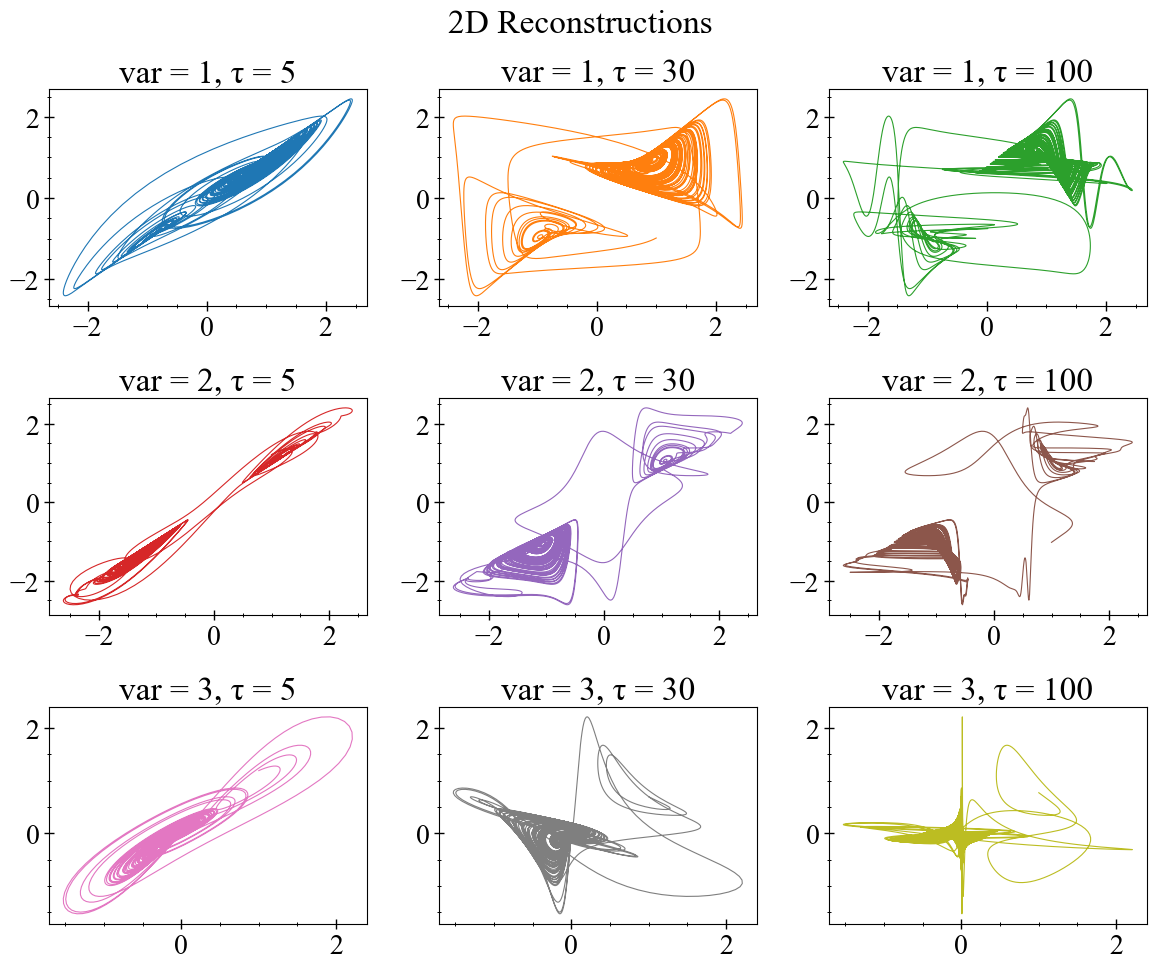

In [24]:
using DynamicalSystems, PyPlot

ds = Systems.gissinger(ones(3)) # 3D continuous chaotic system. Similar to Lorenz
dt = 0.05
data = trajectory(ds, 1000.0, dt = dt)

xyz = columns(data)

figure(figsize = (12,10))
k = 1
for i in 1:3
    for τ in [5, 30, 100]
        R = Reconstruction(xyz[i], 2, τ)
        ax = subplot(3,3,k)
        plot(R[:, 1], R[:, 2], color = "C$(k-1)", lw = 0.8)
        title("var = $i, τ = $τ")
        k+=1
    end
end

tight_layout()
suptitle("2D Reconstructions")
subplots_adjust(top=0.9);

How does this compare to the "real" two-dimensional representation of the system?

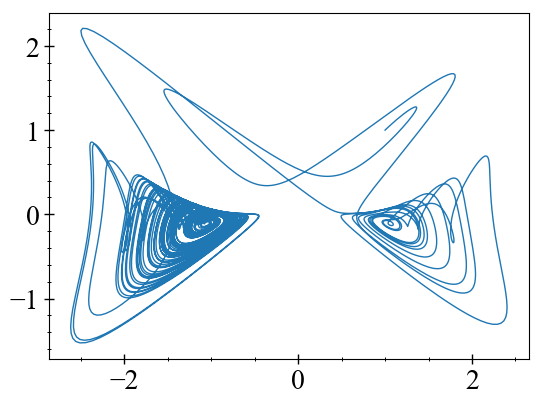

In [25]:
figure(figsize=(6,4))
plot(data[:, 2], data[:, 3], lw=1.0);

---

# `Reconstruction <: AbstractDataset`
A `Reconstruction` instance can be passed around and used exactly like a `Dataset`!

In [26]:
# data comes from gissinger system
R = Reconstruction(data[:, 1], 2, 30)
R[31:end, 1] == R[1:end-30, 2]

true

In [28]:
a = 0.0
for point ∈ R
    a += mean(point)
end
a/length(R)

0.6786109020458012

We will also use this demonstration to show how some quantities remain invariant under a reconstruction.

In [29]:
R = Reconstruction(data[:, 1], 3, 30) # D=2 is not best for this system. D = 3 is better!

# information dimension of Reconstruction
I1 = information_dim(R)

# information dimension of the attractor directly
I2 = information_dim(data)

println("Reconstructed attractor dimension: $I1")
println("Original attractor dimension: $I2")

Reconstructed attractor dimension: 1.7636719663039608
Original attractor dimension: 1.7489325489667893


# Estimating Reconstruction Parameters

It is important to understand that even though Taken's theorem is 99% magic, it is **not** 100%. One still has to choose "appropriately good" values for both the delay time as well as the reconstruction dimension! Thankfully, **DynamicalSystems.jl** has some support for that as well ;)

In [32]:
?estimate_delay

search: estimate_delay estimate_dimension



```
estimate_delay(s, method::String) -> τ
```

Estimate an optimal delay to be used in [`Reconstruction`](@ref).

The `method` can be one of the following:

  * `first_zero` : find first delay at which the auto-correlation function becomes 0.
  * `first_min` : return delay of first minimum of the auto-correlation function.
  * `exp_decay` : perform an exponential fit to the `abs.(c)` with `c` the auto-correlation function of `s`. Return the exponential decay time `τ` rounded to an integer.


---

Unfortunately, *at the moment* the `estimate_delay` methods do not work well for correlation functions that decay exponentially. Therefore one should be careful when using them.

In [33]:
s = data[:, 1] # first coordinate of the system
estimate_delay(s, "first_min"), estimate_delay(s, "first_zero"), estimate_delay(s, "exp_decay")

(106, 2001, 1429)

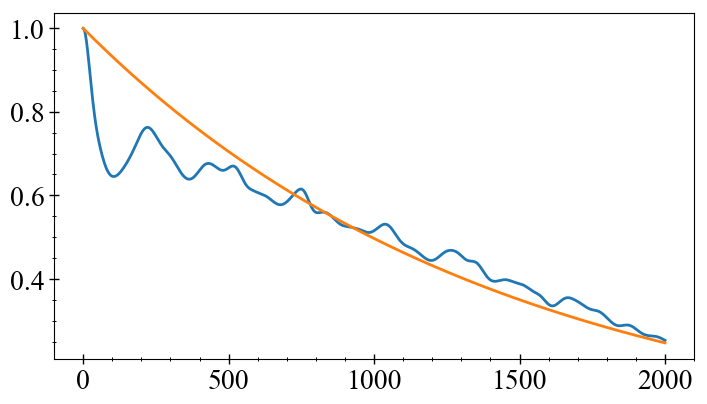

In [35]:
# estimate_delay is not "bugged". It does do what it says
using StatsBase
c = autocor(s, 0:length(s)÷10)
figure(figsize = (8,4)); plot(c)
τ = estimate_delay(s, "exp_decay")
plot([exp(-t/τ) for t in 0:2000]);

---
## Estimating the Dimension

In [36]:
?estimate_dimension

search: estimate_dimension



```
estimate_dimension(s::AbstractVector, τ:Int, Ds = 1:6) -> E1s
```

Estimate an optimal embedding dimension to be used in [`Reconstruction`](@ref).

## Description

Given the scalar timeseries `s` and the embedding delay `τ` compute the values of `E1` for each `D ∈ Ds`, according to Cao's Method [1].

Return the vector of all computed `E1`s. To estimate a dimension from this, find the dimension for which the value `E1` saturates, at some value around 1.

*Note: This method does not work for datasets with perfectly periodic signals.*

## References

[1] : Liangyue Cao, [Physica D, pp. 43-50 (1997)](https://doi.org/10.1016/S0167-2789(97)00118-8)


The paper [1] suggests that when the quantity `E1` returned by `estimate_dimension` saturates, you have found the "optimal" embedding dimension (**don't trust me though! read the paper!**)

In [37]:
E1s = estimate_dimension(s, 30, 1:6)

6-element Array{Float64,1}:
 7.79116e-6
 0.114437  
 0.863397  
 0.949883  
 0.981739  
 0.96135   

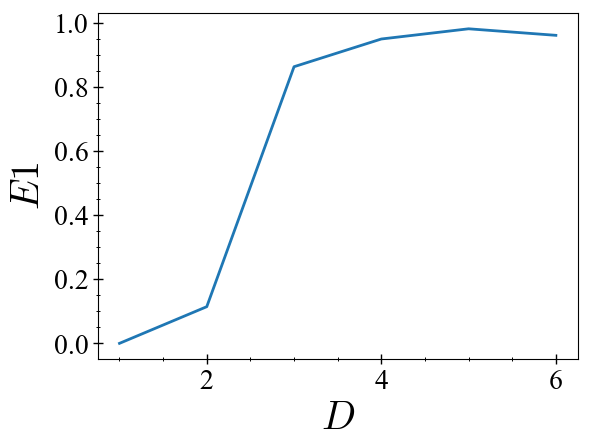

In [39]:
figure(figsize = (6,4))
plot(1:6, E1s);
ylabel("\$E1\$"); xlabel("\$D\$");

From this plot we see that the "optimal" embedding dimension is 3 or 4 (debetable).

# Multiple-time, multiple-timeseries Reconstructions

The `Reconstruction` we have seen so far is just a "Vanilla version"...

---

Let's make a using `Reconstruction` multiple different delay times. 

* This is trying to capture the effect of multiple timescales existing in a system.

In [42]:
s = data[:, 1] # first coordinate of the system
delays = [0, 35, 200]
# simply pass many delays instead of a single delay time
R = Reconstruction(s, 3, delays)

(D=3, τ=[0, 35, 200]) - delay coordinates Reconstruction
 1.0       -1.1359    -1.80212
 0.953553  -1.16077   -1.81021
 0.90227   -1.18424   -1.8179 
 0.846142  -1.20646   -1.82518
 0.785246  -1.22754   -1.83203
 0.719745  -1.24759   -1.83841
 0.649903  -1.26671   -1.8443 
 0.576079  -1.28499   -1.84965
 0.498731  -1.30249   -1.85442
 0.418402  -1.31927   -1.85856
 0.335711  -1.33538   -1.86199
 0.251332  -1.35085   -1.86467
 0.165978  -1.3657    -1.8665 
 ⋮                            
 0.617717   0.903496   1.15459
 0.638141   0.903627   1.15559
 0.65765    0.903556   1.15645
 0.676238   0.903296   1.15717
 0.693903   0.902861   1.15773
 0.710651   0.902262   1.15813
 0.726493   0.901513   1.15837
 0.741445   0.900624   1.15843
 0.755526   0.899607   1.15833
 0.768758   0.898473   1.15804
 0.781167   0.897233   1.15756
 0.792779   0.895896   1.1569 


---

In addition, let's say that you have two measured timeseries from an experiment. Should you just discard one and only use the other for a `Reconstruction` ? 

*Nope!* You can use both of them!

* The docstring of `Reconstruction` describes how the function behaves when multiple timeseries are given. 
* For the method to work, the amount of timeseries must be known by type. 
* With a `Dataset` this is possible!

In [44]:
twots = data[:, 1:2]
typeof(twots)

DynamicalSystemsBase.Dataset{2,Float64}

In [45]:
R = Reconstruction(twots, 2, 35)

(B=2, D=2, τ=35) - delay coordinates multi-dimensional Reconstruction
 1.0        1.0       -1.1359    0.675274
 0.953553   1.04482   -1.16077   0.640501
 0.90227    1.08889   -1.18424   0.606357
 0.846142   1.13164   -1.20646   0.57279 
 0.785246   1.17243   -1.22754   0.539734
 0.719745   1.21067   -1.24759   0.507115
 0.649903   1.24574   -1.26671   0.474849
 0.576079   1.27708   -1.28499   0.442847
 0.498731   1.30417   -1.30249   0.411012
 0.418402   1.32655   -1.31927   0.379243
 0.335711   1.34386   -1.33538   0.347436
 0.251332   1.35583   -1.35085   0.315483
 0.165978   1.36233   -1.3657    0.283272
 ⋮                                       
 1.10999   -0.81224    1.36654  -0.685503
 1.11702   -0.807642   1.37416  -0.683145
 1.12406   -0.803096   1.3818   -0.680882
 1.13111   -0.798603   1.38943  -0.678719
 1.13819   -0.794162   1.39708  -0.676658
 1.14528   -0.789774   1.40473  -0.674705
 1.15239   -0.785438   1.41238  -0.672864
 1.15951   -0.781156   1.42003  -0.671138
 1.166

**Taking it to the extreme**, you can have multiple delay times and multiple timeseries at the same time! 

* It gets kind of complex at this case, because the delay times now have to be a matrix!

In [46]:
delays = [0 0; 35 64]

2×2 Array{Int64,2}:
  0   0
 35  64

In [47]:
R = Reconstruction(twots, 2, delays)

(B=2, D=2, τ=[0 0; 35 64]) - delay coordinates multi-dimensional Reconstruction
 1.0        1.0       -1.1359   -0.41971 
 0.953553   1.04482   -1.16077  -0.476575
 0.90227    1.08889   -1.18424  -0.53557 
 0.846142   1.13164   -1.20646  -0.596631
 0.785246   1.17243   -1.22754  -0.659639
 0.719745   1.21067   -1.24759  -0.724409
 0.649903   1.24574   -1.26671  -0.790684
 0.576079   1.27708   -1.28499  -0.858123
 0.498731   1.30417   -1.30249  -0.926292
 0.418402   1.32655   -1.31927  -0.994659
 0.335711   1.34386   -1.33538  -1.06259 
 0.251332   1.35583   -1.35085  -1.12937 
 0.165978   1.36233   -1.3657   -1.19416 
 ⋮                                       
 0.911337  -0.967789   1.15239  -0.685503
 0.918062  -0.961749   1.15951  -0.683145
 0.924797  -0.955752   1.16665  -0.680882
 0.931541  -0.949798   1.17382  -0.678719
 0.938293  -0.943889   1.181    -0.676658
 0.945054  -0.938026   1.1882   -0.674705
 0.951822  -0.932209   1.19542  -0.672864
 0.958598  -0.92644    1.20266  -0.671

In [48]:
?Reconstruction

search: Reconstruction MDReconstruction



```
Reconstruction(s::AbstractVector, D, τ) <: AbstractDataset
```

`D`-dimensional delay-coordinates reconstruction object with delay `τ`, created from a timeseries `s`.

## Description

If `τ` is an integer, then the $n$th row of a `Reconstruction` is

$$
(s(n), s(n+\tau), s(n+2\tau), \dots, s(n+(D-1)\tau))
$$

If instead `τ` is a vector of integers, so that `length(τ) == D`, then the $n$th row is

$$
(s(n+\tau[1]), s(n+\tau[2]), s(n+\tau[3]), \dots, s(n+\tau[D]))
$$

The reconstruction object `R` can have same invariant quantities (like e.g. lyapunov exponents) with the original system that the timeseries were recorded from, for proper `D` and `τ` [1, 2].

The case of different delay times allows reconstructing systems with many time scales, see [3].

## Multi-dimensional `Reconstruction`

To make a reconstruction out of a multi-dimensional timeseries (i.e. trajectory) use

```julia
Reconstruction(tr::SizedAray{A, B}, D, τ)
Reconstruction(tr::AbstractDataset{B}, D, τ)
```

with `B` the "base" dimensions.

If the trajectory is for example $(x, y)$, then the $n$th row is

$$
(x(n), y(n), x(n+\tau), y(n+\tau), \dots, x(n+(D-1)\tau), y(n+(D-1)\tau))
$$

for integer `τ` and if `τ` is an `AbstractMatrix{Int}`, so that `size(τ) == (D, B)`, then the $n$th row is

$$
(x(n+\tau[1, 1]), y(n+\tau[1, 2]), \dots, x(n+\tau[D, 1]), y(n+\tau[D, 2]))
$$

Note that a reconstruction created this way will have `B*D` total dimensions and *not* `D`, as a result of each dimension of `s` having `D` delayed dimensions.

## References

[1] : F. Takens, *Detecting Strange Attractors in Turbulence — Dynamical Systems and Turbulence*, Lecture Notes in Mathematics **366**, Springer (1981)

[2] : T. Sauer *et al.*, J. Stat. Phys. **65**, pp 579 (1991)

[3] : K. Judd & A. Mees, [Physica D **120**, pp 273 (1998)](https://www.sciencedirect.com/science/article/pii/S0167278997001188)
